# Diabetes Prediction Dataset

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from scipy.stats import entropy

# load the dataset
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# Functions

In [27]:
def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        # "GaussianNB": GaussianNB(),
        # "LDA":LinearDiscriminantAnalysis(),
        # "GPC":GaussianProcessClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)

def automate_pca(pca_components, X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  
  models = run_all_models(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded)
  print(models)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [3]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [4]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [5]:
df.duplicated().sum()

3854

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [8]:
df["smoking_history"].value_counts()

smoking_history
never          34398
No Info        32887
former          9299
current         9197
not current     6367
ever            3998
Name: count, dtype: int64

### Notice the convoluted language here, what does 'ever' mean here? Also what is the different between former and not current? Is there an amount of days divider that separates the two categories? It might be a good idea to consolidate some of these categories until we get more information. This is why SME's can offer great insight

### In this case, we should possibly combine ever + former + not current + current. Until we get more robust information. However, my guess is that there is a divider of days that is significant in terms of predicting if someone is between a former and on/off smoker

In [9]:
df["gender"].value_counts()

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64

### Only 18 rows with gender marked as 'other', this might impact the vast majority of rows, it maybe a good idea to remove those rows

In [10]:
calculate_entropy(df)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
entropy,0.981835,6.332719,0.393668,0.24596,2.15991,9.569614,3.787083,3.865964,0.4305


In [11]:
target = df.values[:,-1]

counter = Counter(target)
for k,v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%d.3%%" % (k,v, per))

Class=0, Count=87664, Percentage=91.3%
Class=1, Count=8482, Percentage=8.3%


### We have an imbalanced dataset here, observing many notebooks for this database. Many have made the mistake of receiving a high accuracy score and ending the analysis. This is a big no no in immbalanced datasets. The experienced engineer should test on multuple subsets of data while using under and over sampling methods and come away with the best model. However, given that we have close to 97k records, we might have to drop a large amount from the majority class in order to test all of the algorithms I would like to test given that running these models on this large of a set will likely send my laptop to a medic, we will see how I decide to resolve this issue.

# Data Preparation

In [12]:
df = df[df['gender'] != "other"]

In [13]:
df["gender"] = df["gender"].apply(lambda x: 0 if x == "Female" else 1 )
df["smoking_history"] = df["smoking_history"].apply(lambda x: 0 if x == "No Info" else 1 if x in ["former", "ever", "not current", "current"] else 2 )

<Axes: xlabel='gender'>

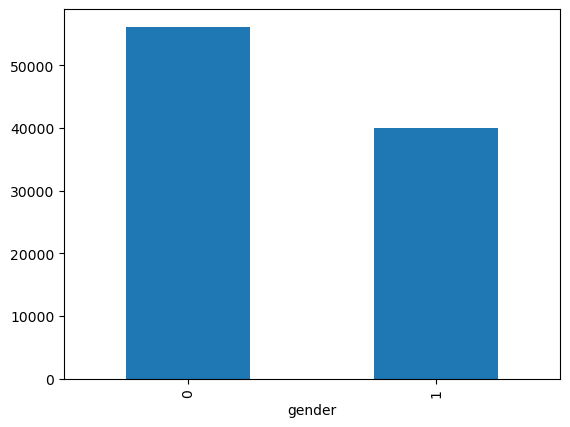

In [14]:
df["gender"].value_counts().plot.bar()

<Axes: xlabel='heart_disease'>

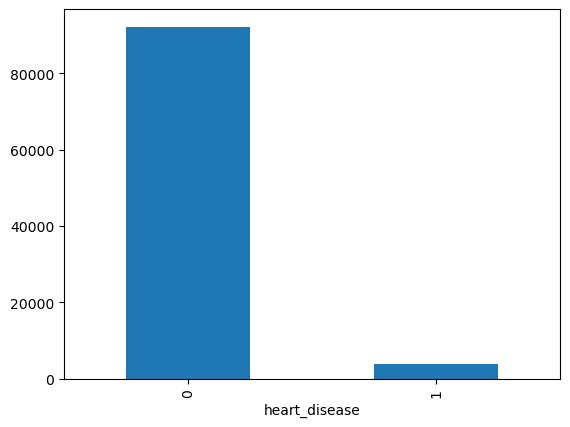

In [15]:
df["heart_disease"].value_counts().plot.bar()

### It is important to note that heart disease is also imbalanced

<Axes: xlabel='smoking_history'>

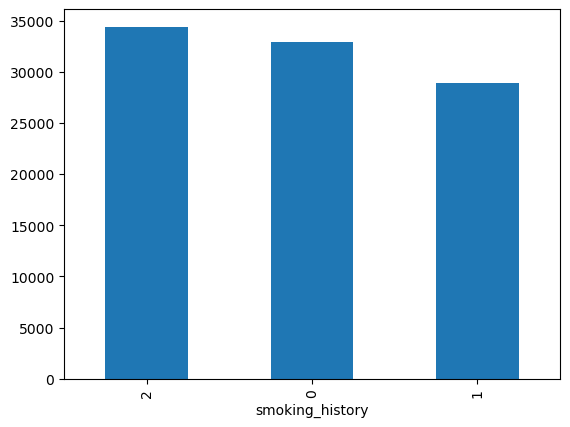

In [16]:
df["smoking_history"].value_counts().plot.bar()

In [17]:
df["smoking_history"].value_counts()

smoking_history
2    34398
0    32887
1    28861
Name: count, dtype: int64

# Visuals

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/18781

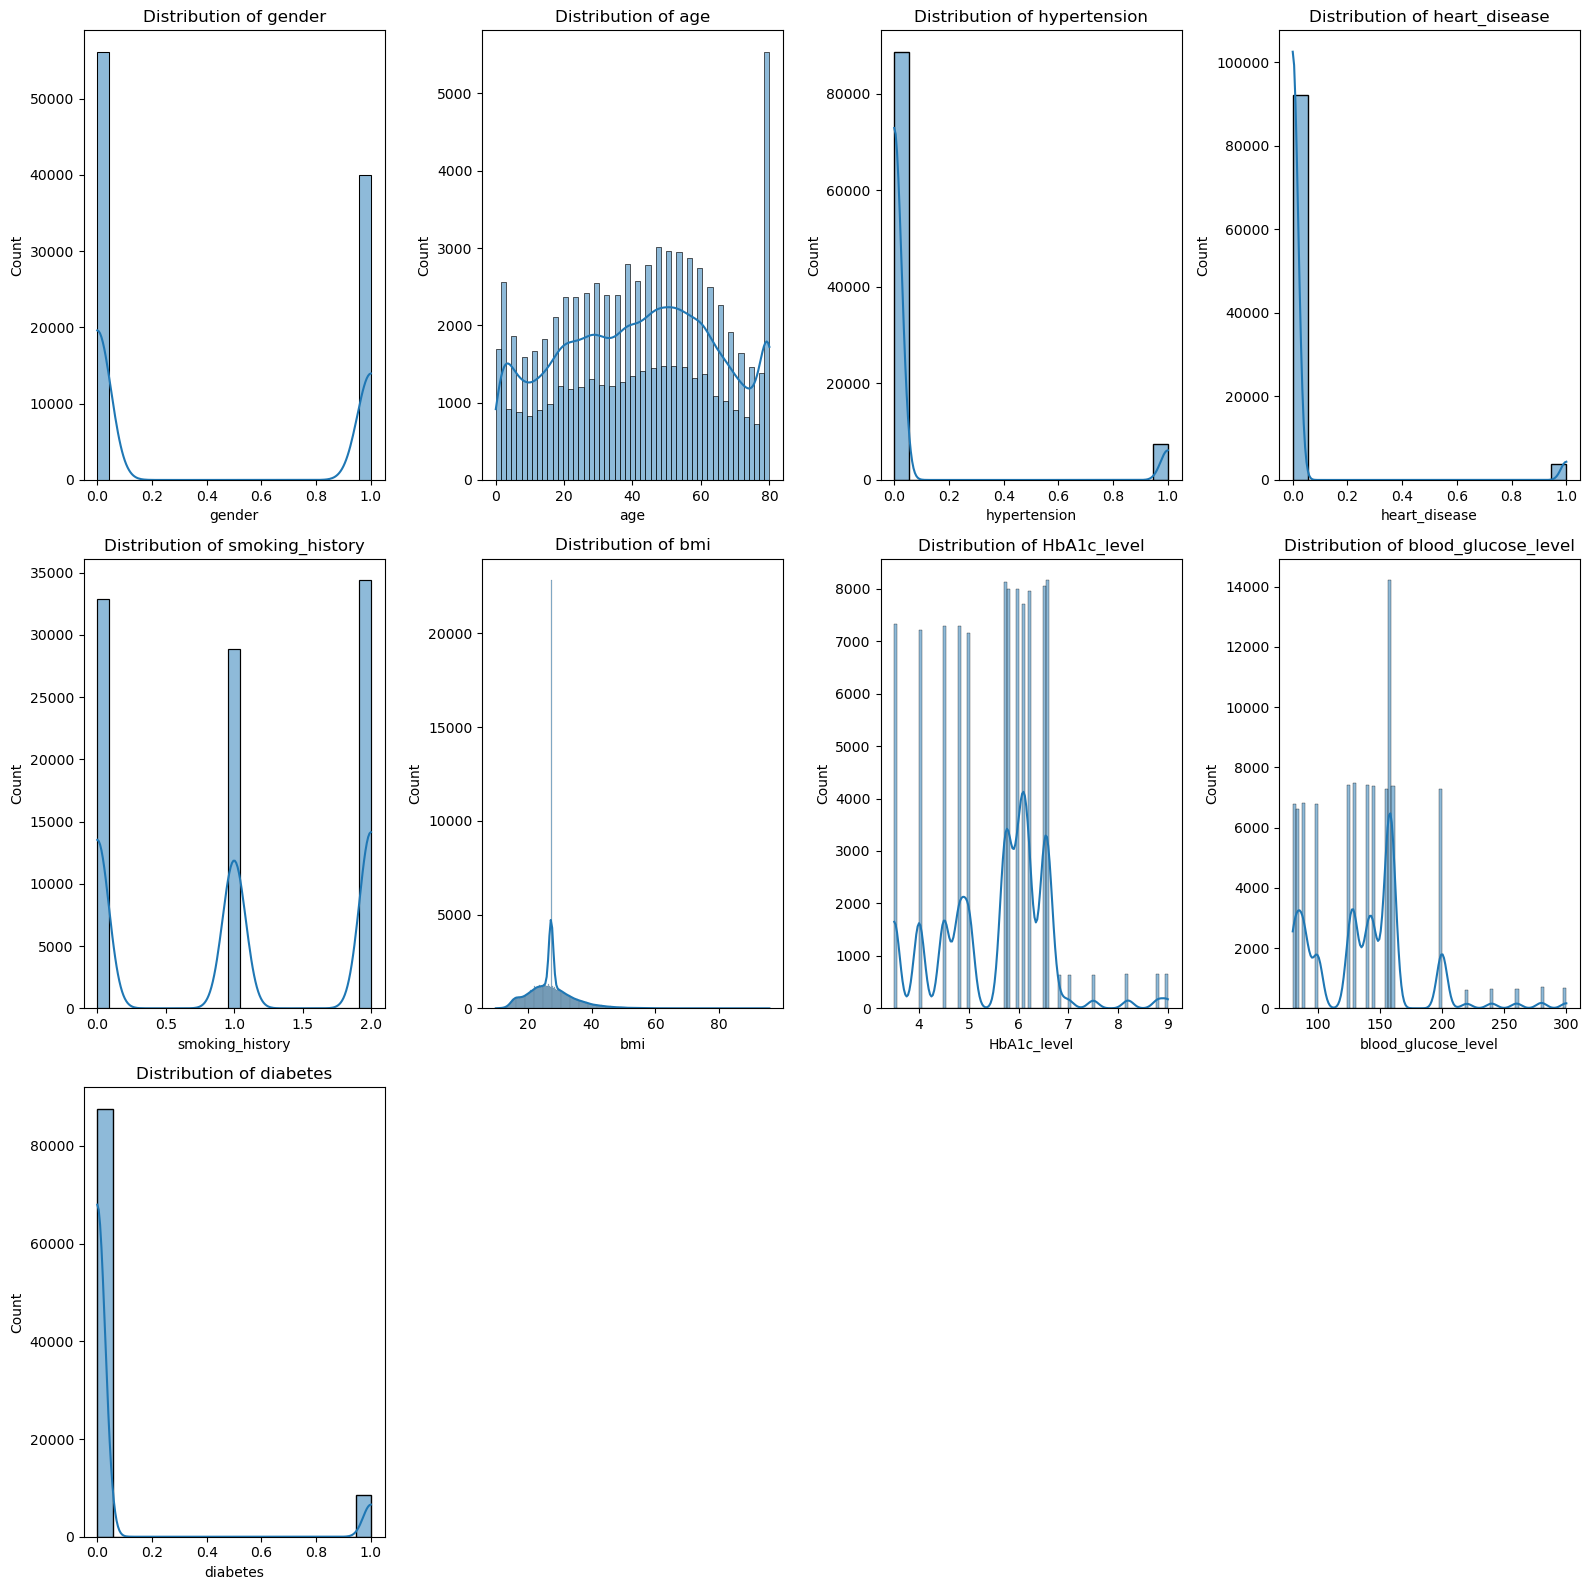

In [18]:
df_width= len(df.columns)
rows = (df_width +3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_81884/33908

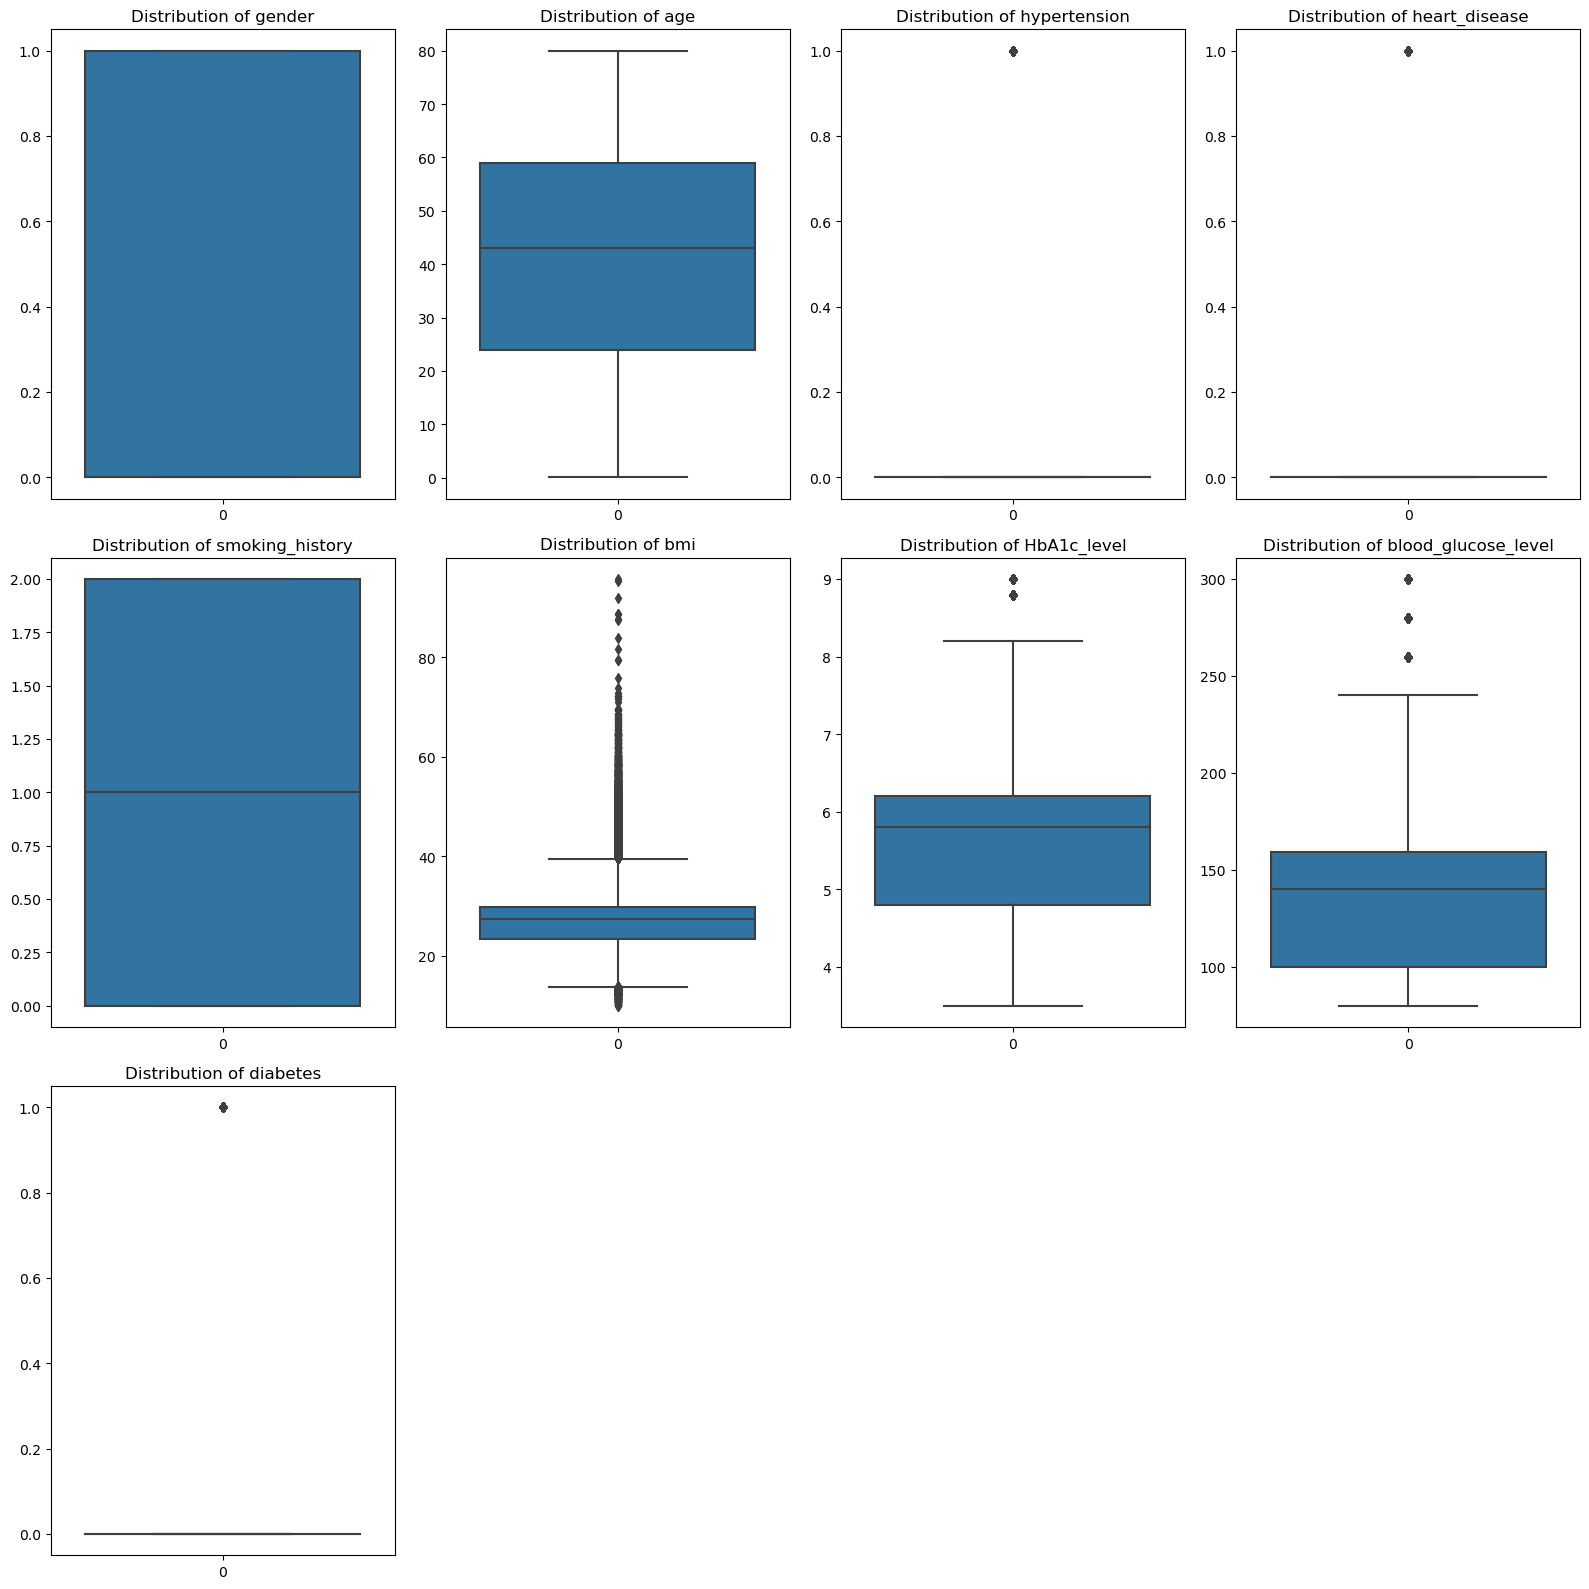

In [19]:
df_width= len(df.columns)
rows = (df_width +3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

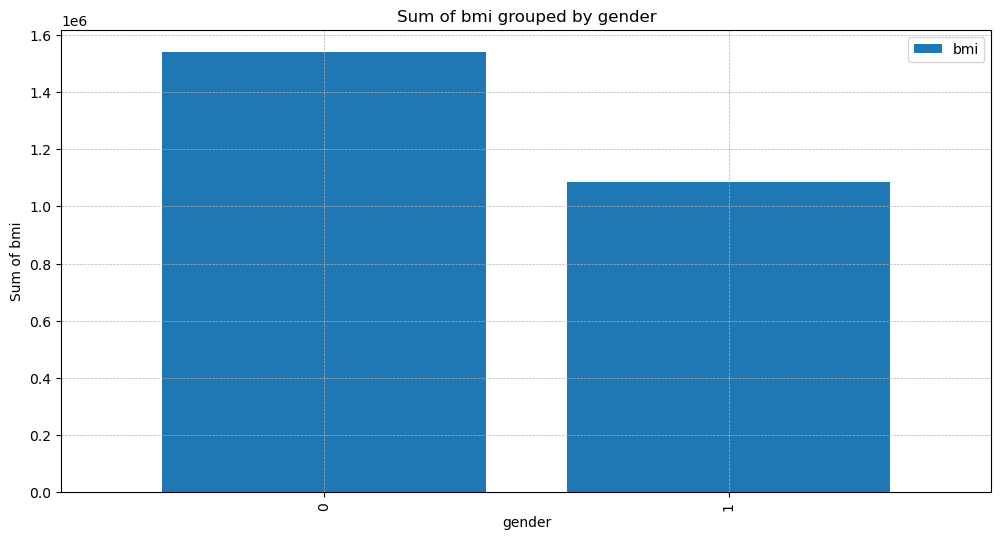

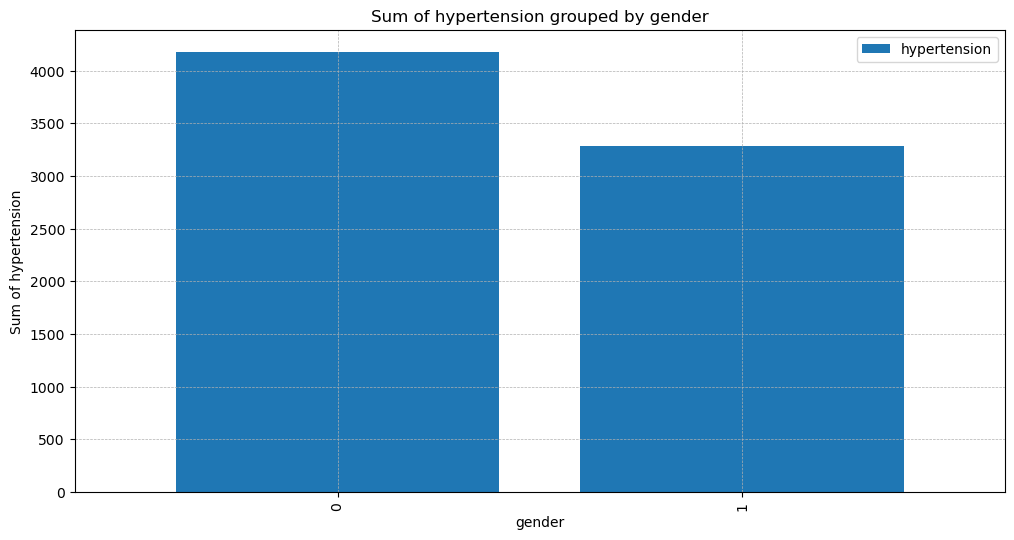

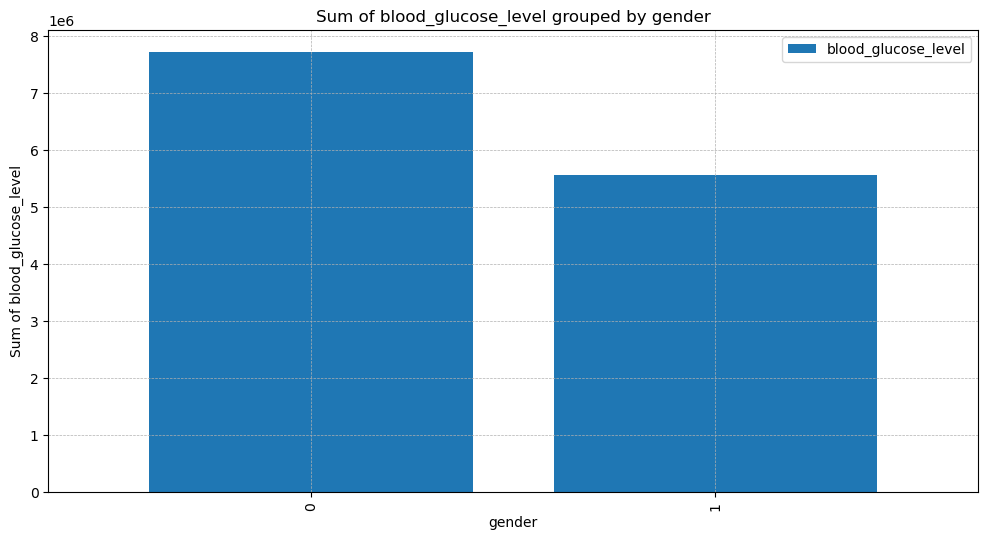

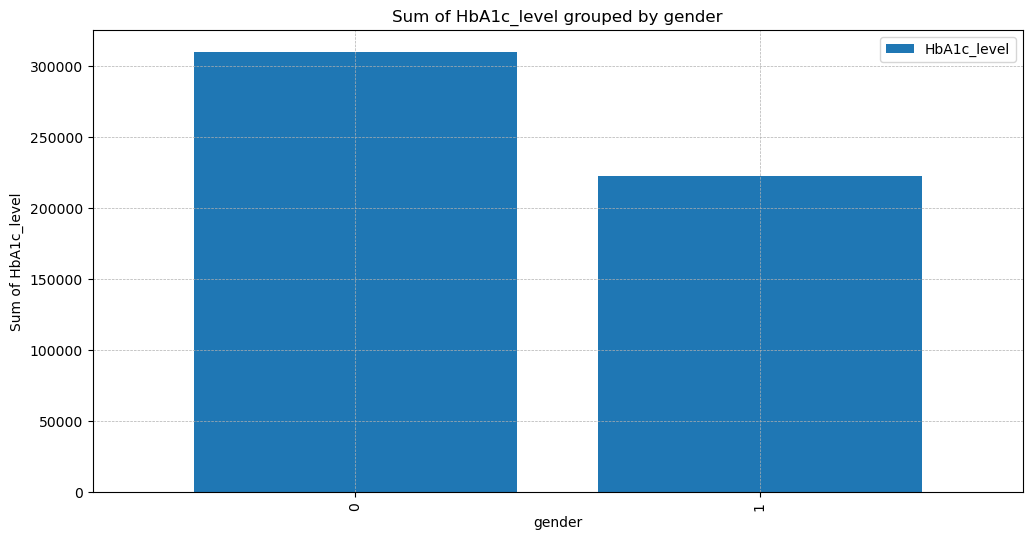

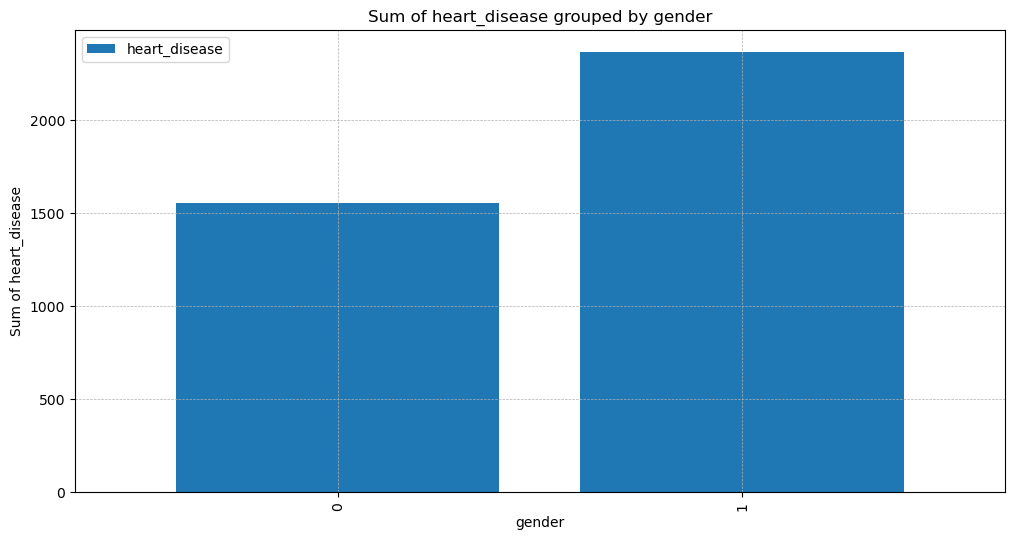

In [20]:
# Set a larger figure size and higher resolution
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

interested_columns = ["bmi", "hypertension", "blood_glucose_level", "HbA1c_level", "heart_disease"]

for col in interested_columns:
    df_grouped = df.groupby("gender")[col].sum().reset_index()
    
    # Create the plot
    df_grouped.plot(kind="bar", x="gender", y=col, width=0.8) # Adjust bar width as needed
    
    # Set labels and title
    plt.xlabel("gender")
    plt.ylabel(f"Sum of {col}")
    plt.title(f"Sum of {col} grouped by gender")
    
    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

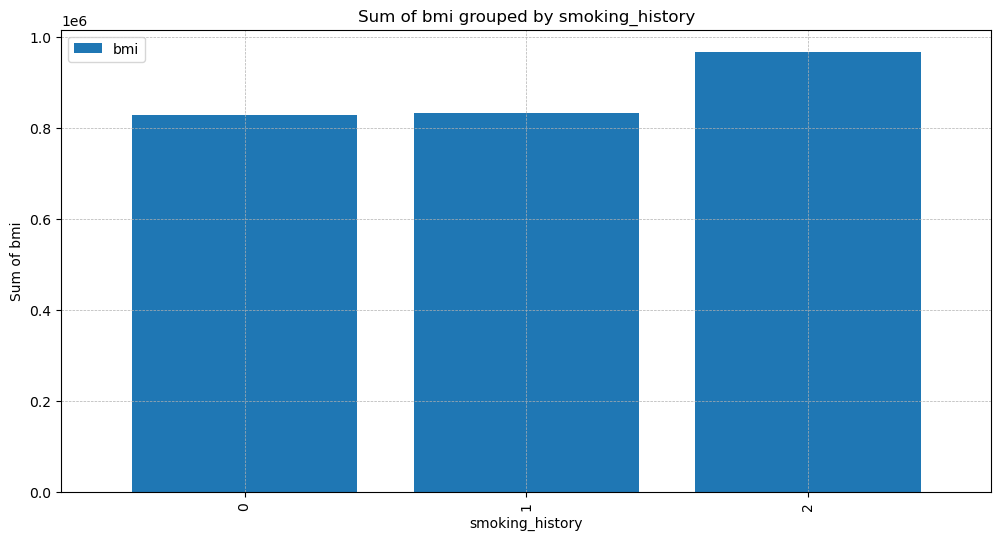

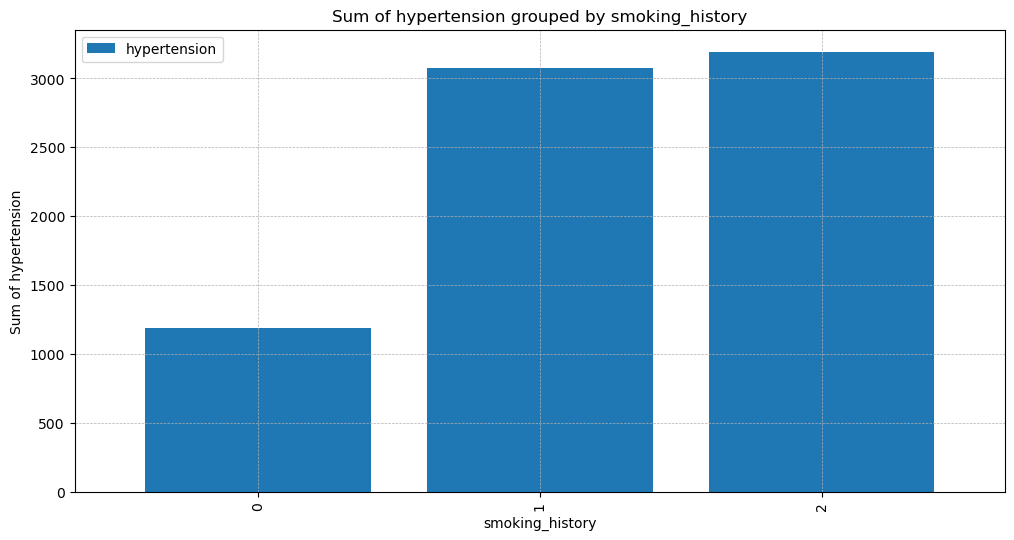

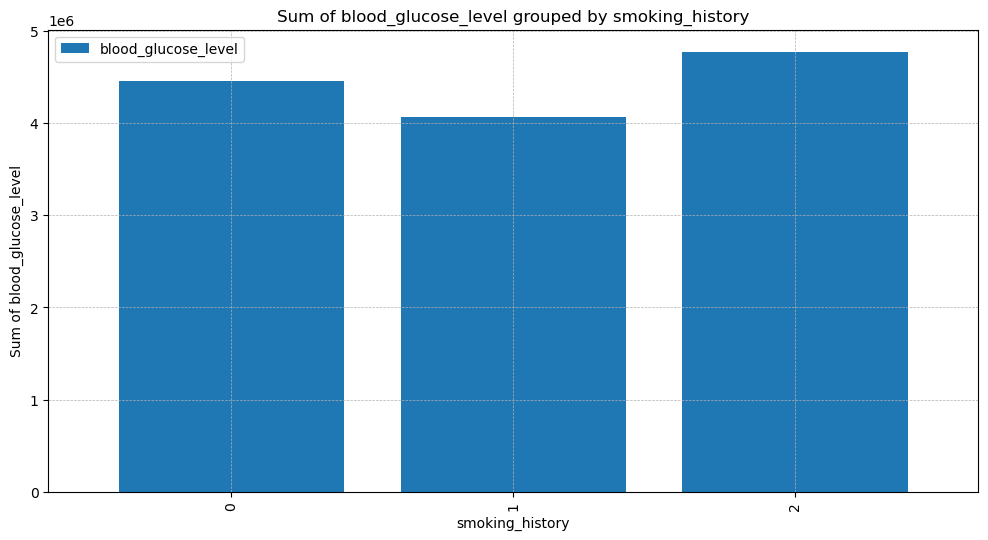

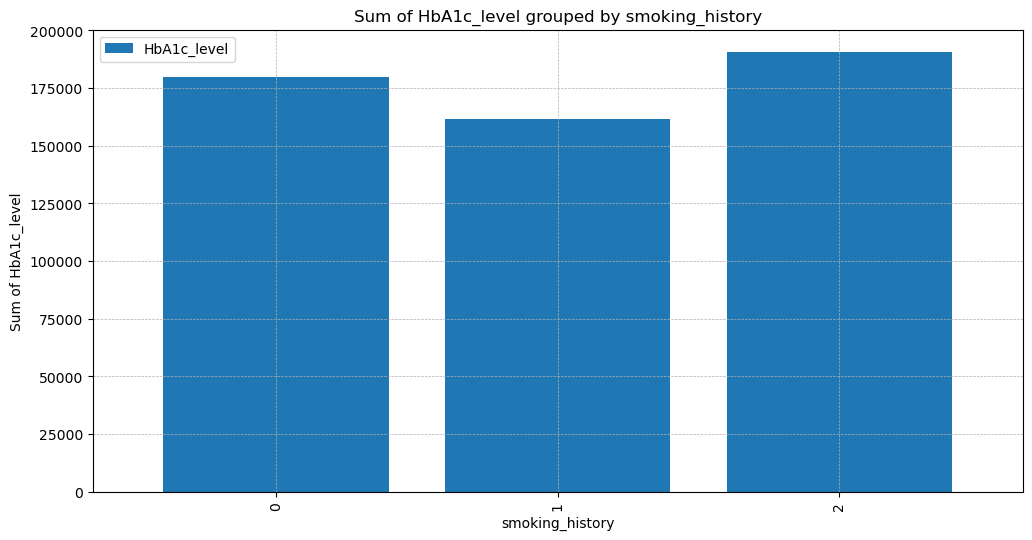

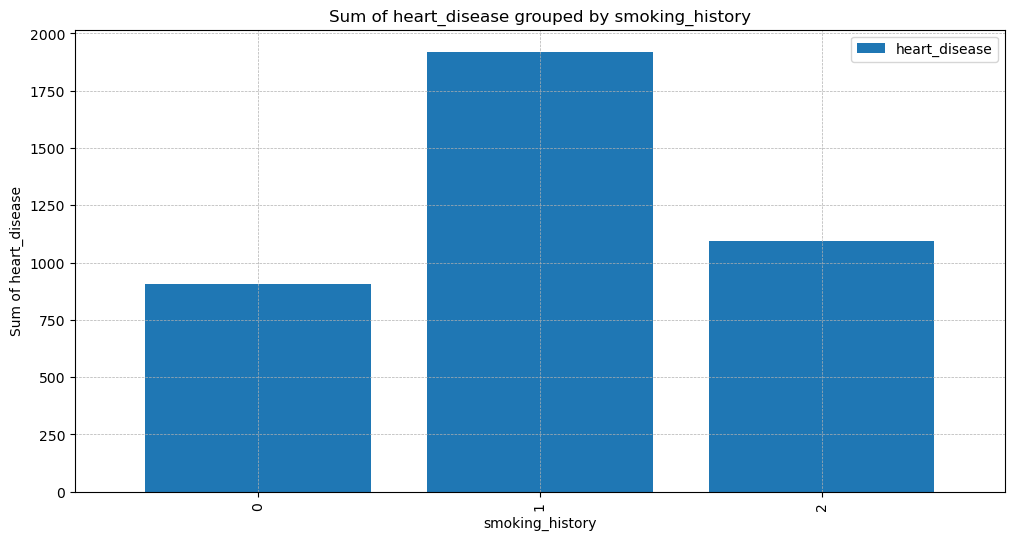

In [21]:
# Set a larger figure size and higher resolution
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

interested_columns = ["bmi", "hypertension", "blood_glucose_level", "HbA1c_level", "heart_disease"]

for col in interested_columns:
    df_grouped = df.groupby("smoking_history")[col].sum().reset_index()
    
    # Create the plot
    df_grouped.plot(kind="bar", x="smoking_history", y=col, width=0.8) # Adjust bar width as needed
    
    # Set labels and title
    plt.xlabel("smoking_history")
    plt.ylabel(f"Sum of {col}")
    plt.title(f"Sum of {col} grouped by smoking_history")
    
    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

<Axes: >

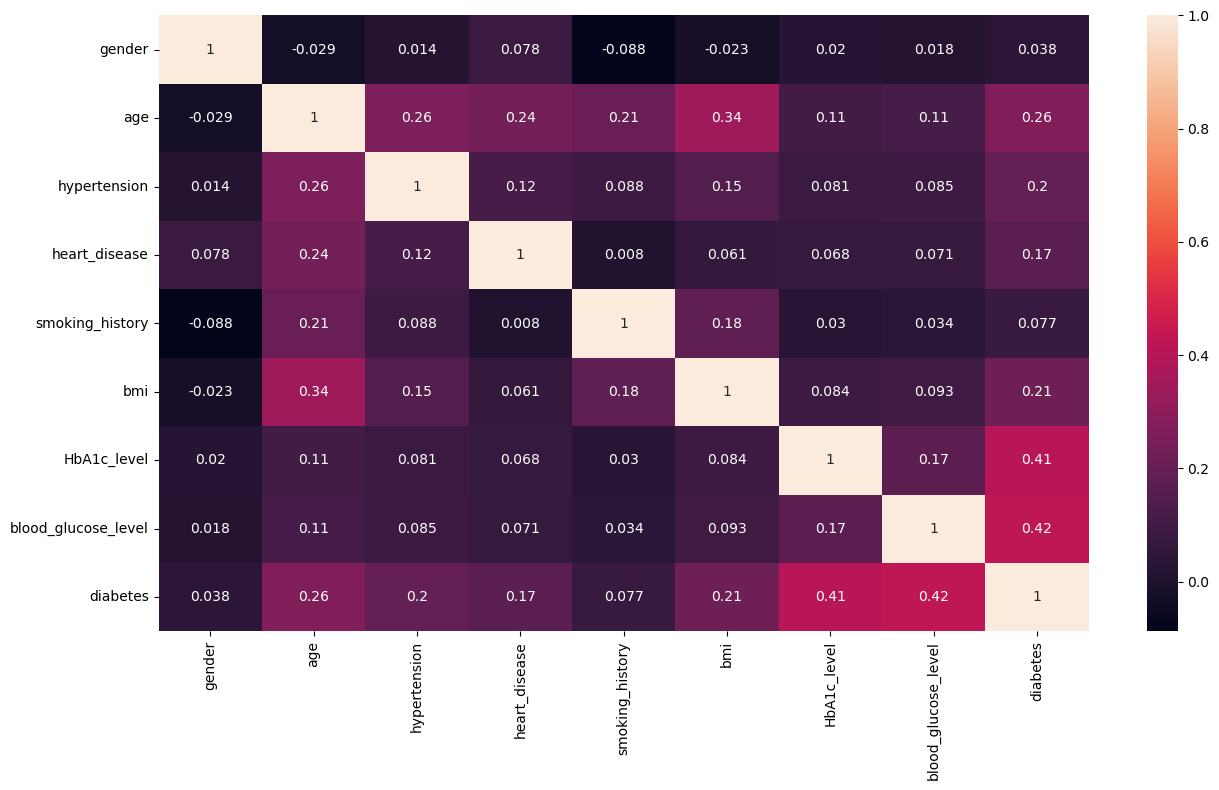

In [22]:
relations = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(data=relations, annot=True)

<Axes: xlabel='diabetes', ylabel='blood_glucose_level'>

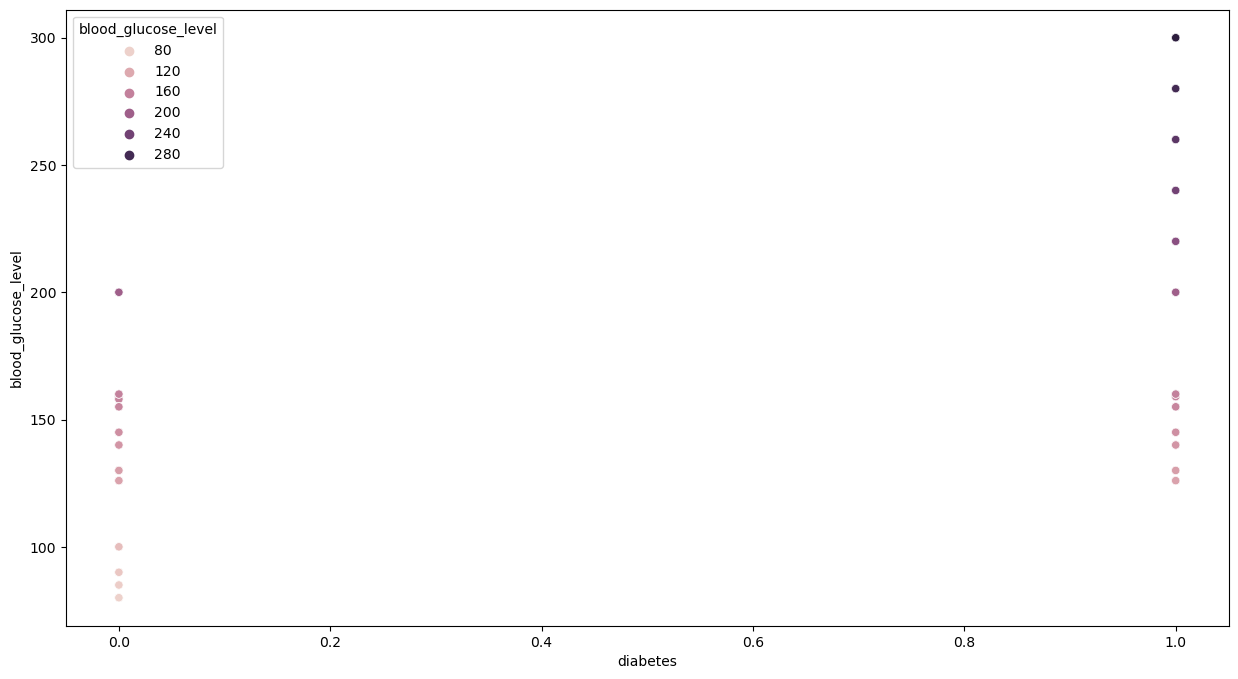

In [23]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x="diabetes", y="blood_glucose_level", hue="blood_glucose_level")

<Axes: xlabel='diabetes', ylabel='HbA1c_level'>

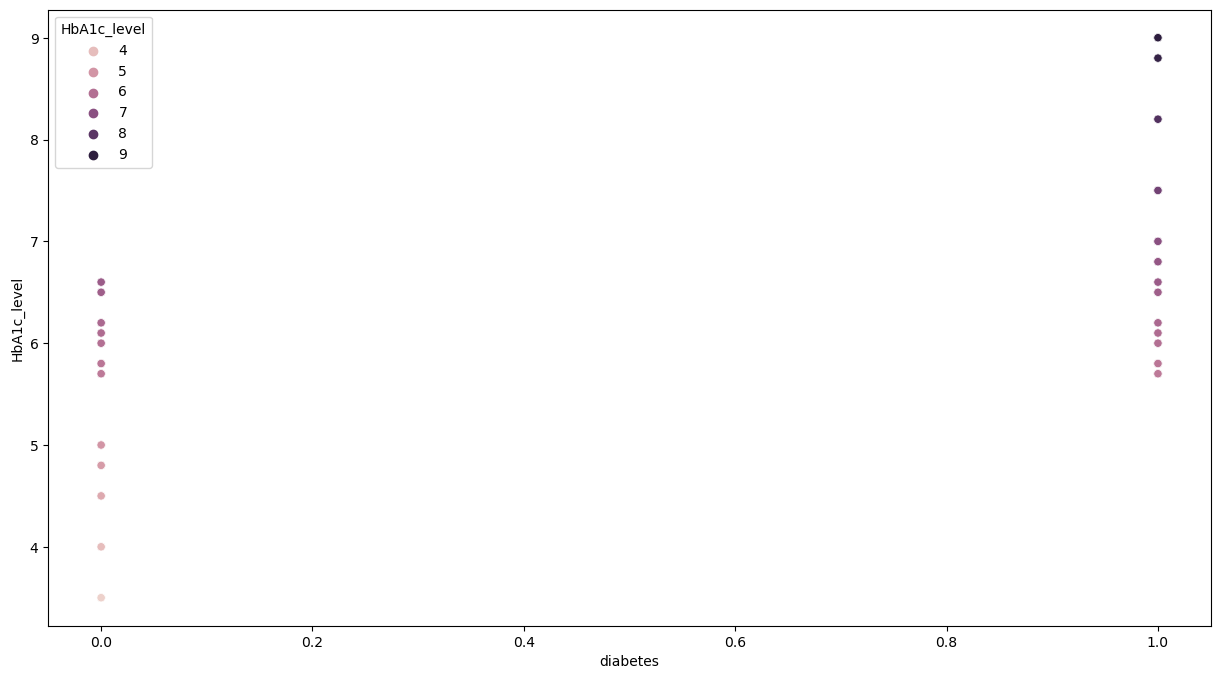

In [24]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x="diabetes", y="HbA1c_level", hue="HbA1c_level")

# Model Evaluation

In [25]:
from sklearn.metrics import fbeta_score


def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

(96146, 8) (96146,) Counter({0: 87664, 1: 8482})
Mean F2: 0.326 (0.000)


## Given that this model is predicting diabetes, my analysis will be primiarly focused on minimizing type II errors which means preventing False negatives. The Baseline F2 score should be better than 0.37% percent

# Spot Check Algorithms

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = run_all_models(X_train_scaled, X_test_scaled, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False)

2024-04-03 15:42:56.436098: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


601/601 [==============================] - 0s 474us/step - loss: 0.0896 - accuracy: 0.9700


,Model,Accuracy
5,GradientBoostingClassifier,0.970983
6,Sequential,0.969995
3,RandomForestClassifier,0.968539
1,SVC,0.960946
4,KNeighborsClassifier,0.959490
0,LogisticRegression,0.957202
2,DecisionTreeClassifier,0.948310


# Advanced Model Metrics

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  # DTC
  models.append(DecisionTreeClassifier())
  names.append('DTC')
  
  return models, names

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # Wrap the model in a pipeline with StandardScaler
  pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', models[i])])
  # Evaluate the model
  scores = evaluate_model(X, y, pipeline)  # Replace X, y with your data
  results.append(scores)
  # summarize and store
  print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>RFC 0.725 (0.016)
>GBC 0.725 (0.016)
>KNN 0.674 (0.018)
>SVC 0.640 (0.017)
>LR 0.667 (0.017)
>DTC 0.732 (0.013)


# Important Lesson for ML Engineers

### When working with imbalanced data sets, you cannot run a model, receive a high score and call it a day. Due to the imbalanced data set such as this case where we have 10 to 1 ratio of the majoirty class vs the minoirty class. It is highly likely that the model is overfitting to the dataset and is unable to generalize to new data. In this case that could mean incorrectly mislabeling diabetes which could be life impacting. Its important to test on subsets of data. As we see here, the model tested on subsets of data reveals to be significantly worse.

Model: RFC, Accuracy: 0.968, F2 Score: 0.724


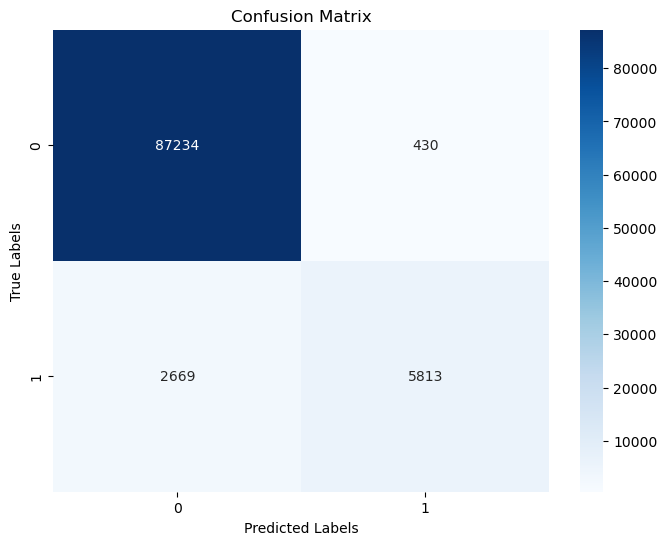

Model: GBC, Accuracy: 0.971, F2 Score: 0.726


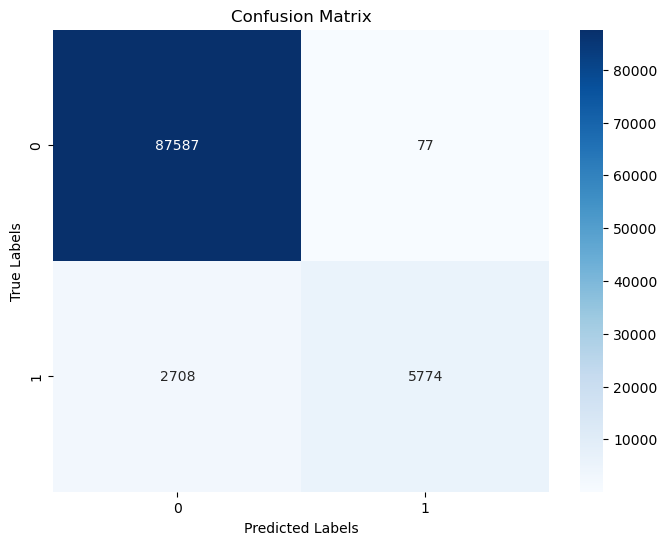

Model: DTC, Accuracy: 0.950, F2 Score: 0.731


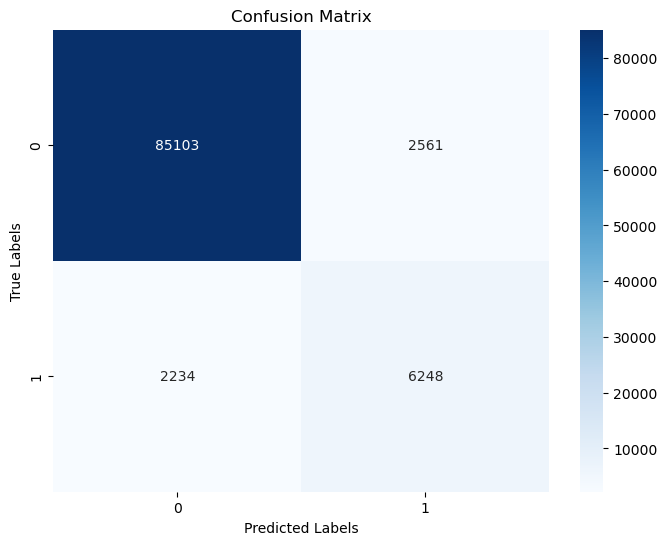

  Model  Accuracy  F1 Score
0   RFC  0.967768  0.723532
1   GBC  0.971034  0.725760
2   DTC  0.950128  0.730983


In [32]:
from sklearn.calibration import cross_val_predict

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)
# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # DTC
  models.append(DecisionTreeClassifier())
  names.append('DTC')
  return models, names

models, names = get_models()
model_performance = []
for i in range(len(models)):
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', models[i])
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=10) 

    # Compute the desired metrics
    accuracy = accuracy_score(y, y_pred)
    f2 = f2_measure(y, y_pred)

    model_performance.append({
        "Model": names[i],
        "Accuracy": accuracy,
        "F1 Score": f2
    })

    print(f"Model: {names[i]}, Accuracy: {accuracy:.3f}, F2 Score: {f2:.3f}")
    
    # Generate the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Convert the model_performance to a DataFrame for easier analysis
performance_df = pd.DataFrame(model_performance)
print(performance_df)

# DTC has the lowest amount of False negatives therefore we will go with this model but notice the accuracy in this instance and how it can fool us.

# Under Sampling Methods to remove some of the majority class examples

In [35]:
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.pipeline import Pipeline as imblearnPipeline
from sklearn.compose import ColumnTransformer

# calculate f2-measure
def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)
# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

# define undersampling models to test
def get_models():
  models, names = list(), list() 
  # TL 
  models.append(TomekLinks()) 
  names.append('TL')
  # ENN
  models.append(EditedNearestNeighbours()) 
  names.append('ENN')
  # RENN 
  models.append(RepeatedEditedNearestNeighbours()) 
  names.append('RENN')
  # OSS
  models.append(OneSidedSelection()) 
  names.append('OSS')
  # NCR 
  models.append(NeighbourhoodCleaningRule()) 
  names.append('NCR')
  return models, names

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
models, names = get_models()
# evaluate each model
for i in range(len(models)):
  # define model to evaluate
  model = DecisionTreeClassifier()
  pipeline = imblearnPipeline(steps=[('scaler', StandardScaler()),('s', models[i]), ('m', model)])
  # evaluate the model and store results
  scores = evaluate_model(X, y, pipeline)
  # summarize and store
  print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))